# Building Model For Predicting Bike Availability

# Loading data and merging into one data frame

In [2]:
import pandas as pd
import numpy as np

availability = pd.read_csv("static/csv/availability.csv")
weather = pd.read_csv("static/csv/current_weather.csv")

df = availability.merge(weather[["weather_desc", "temp", "visibility", "wind_speed", "wind_deg", "timestamp"]], on = ["timestamp"], how = "left")
df.head()

,number,available_bikes,available_bike_stands,status,last_update,timestamp,weather_desc,temp,visibility,wind_speed,wind_deg
0,42,30,0,OPEN,1677185535000,1677185702,NaN,NaN,NaN,NaN,NaN
1,30,4,16,OPEN,1677185621000,1677185702,NaN,NaN,NaN,NaN,NaN
2,54,5,28,OPEN,1677185522000,1677185702,NaN,NaN,NaN,NaN,NaN
3,108,13,22,OPEN,1677185161000,1677185702,NaN,NaN,NaN,NaN,NaN
4,20,6,24,OPEN,1677185529000,1677185702,NaN,NaN,NaN,NaN,NaN


# Cleaning data frame

## Columns - dropping and renaming

In [3]:
df.drop(["status", "last_update"], axis = 1, inplace = True)
df.head()

,number,available_bikes,available_bike_stands,timestamp,weather_desc,temp,visibility,wind_speed,wind_deg
0,42,30,0,1677185702,NaN,NaN,NaN,NaN,NaN
1,30,4,16,1677185702,NaN,NaN,NaN,NaN,NaN
2,54,5,28,1677185702,NaN,NaN,NaN,NaN,NaN
3,108,13,22,1677185702,NaN,NaN,NaN,NaN,NaN
4,20,6,24,1677185702,NaN,NaN,NaN,NaN,NaN


## Rows - dropping rows with no weather data

In [4]:
df.dropna(inplace = True)
df.head()

,number,available_bikes,available_bike_stands,timestamp,weather_desc,temp,visibility,wind_speed,wind_deg
336580,42,16,14,1678113903,light rain,278.81,10000.0,3.09,290.0
336581,30,0,20,1678113903,light rain,278.81,10000.0,3.09,290.0
336582,54,17,16,1678113903,light rain,278.81,10000.0,3.09,290.0
336583,108,14,21,1678113903,light rain,278.81,10000.0,3.09,290.0
336584,20,22,8,1678113903,light rain,278.81,10000.0,3.09,290.0


## Date and Time - changing Unix timestamp

In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit = "s")
df["month"] = df['timestamp'].dt.month  # 1-12
df["day"] = df['timestamp'].dt.dayofweek  # 0-6
df["hour"] = df['timestamp'].dt.hour  # 0-23

df.drop("timestamp", axis = 1, inplace = True)
df.head()

,number,available_bikes,available_bike_stands,weather_desc,temp,visibility,wind_speed,wind_deg,month,day,hour
336580,42,16,14,light rain,278.81,10000.0,3.09,290.0,3,0,14
336581,30,0,20,light rain,278.81,10000.0,3.09,290.0,3,0,14
336582,54,17,16,light rain,278.81,10000.0,3.09,290.0,3,0,14
336583,108,14,21,light rain,278.81,10000.0,3.09,290.0,3,0,14
336584,20,22,8,light rain,278.81,10000.0,3.09,290.0,3,0,14


## Reindexing columns

In [6]:
column_order = ["month", "day", "hour", "number", "available_bike_stands", "temp", "weather_desc", "visibility", "wind_speed", "wind_deg", "available_bikes"]
df = df.reindex(columns = column_order)
df.head()

,month,day,hour,number,available_bike_stands,temp,weather_desc,visibility,wind_speed,wind_deg,available_bikes
336580,3,0,14,42,14,278.81,light rain,10000.0,3.09,290.0,16
336581,3,0,14,30,20,278.81,light rain,10000.0,3.09,290.0,0
336582,3,0,14,54,16,278.81,light rain,10000.0,3.09,290.0,17
336583,3,0,14,108,21,278.81,light rain,10000.0,3.09,290.0,14
336584,3,0,14,20,8,278.81,light rain,10000.0,3.09,290.0,22


## Replacing weather_desc values with corresponding weather IDs

When I started scraping the weather data, I never included the weather IDs for each call to the OpenWeather APIs, preferring to pull a description of the weather in English. It has occured to me that it would have been far more useful to scrape the weather IDs for the purposes of training the model. So, I have counted each unique value for weather descriptions from our database, and below I will replace all of the weather description strings in the weather_desc feature of the data frame with their corresponding weather IDs, as described here: https://openweathermap.org/weather-conditions

In [7]:
df["weather_desc"] = df["weather_desc"].replace({"light rain": 500, "broken clouds": 803, "moderate rain": 501, "light intensity drizzle": 300, "clear sky": 800, "overcast clouds": 804, 
                                                 "scattered clouds": 802, "few clouds": 801, "snow": 601, "heavy intensity rain": 502, "sleet": 611, "mist": 701, "light snow": 600, 
                                                 "light intensity shower rain": 520, "light intensity drizzle rain": 310, "shower rain": 521, "fog": 741})
df.head()

,month,day,hour,number,available_bike_stands,temp,weather_desc,visibility,wind_speed,wind_deg,available_bikes
336580,3,0,14,42,14,278.81,500,10000.0,3.09,290.0,16
336581,3,0,14,30,20,278.81,500,10000.0,3.09,290.0,0
336582,3,0,14,54,16,278.81,500,10000.0,3.09,290.0,17
336583,3,0,14,108,21,278.81,500,10000.0,3.09,290.0,14
336584,3,0,14,20,8,278.81,500,10000.0,3.09,290.0,22


## Grouping by station number

In [8]:
stations = df.groupby("number")
print(stations.get_group(1))

         month  day  hour  number  available_bike_stands    temp  \
336596       3    0    14       1                      4  278.81   
336711       3    0    14       1                      4  278.56   
336826       3    0    14       1                      4  278.56   
336941       3    0    15       1                      4  278.45   
337056       3    0    15       1                      4  278.30   
...        ...  ...   ...     ...                    ...     ...   
1281012      4    1     8       1                      8  281.88   
1281126      4    1     8       1                      8  281.88   
1281240      4    1     8       1                      8  282.24   
1281354      4    1     8       1                      8  282.24   
1281468      4    1     8       1                      5  282.00   

         weather_desc  visibility  wind_speed  wind_deg  available_bikes  
336596            500     10000.0        3.09     290.0               27  
336711            500     10000.0

# Model building

In [9]:
from sklearn.ensemble import RandomForestRegressor

models = {}

for station_name, station_df in stations:
    x = station_df.drop("available_bikes", axis = 1)
    y = station_df["available_bikes"]
    model = RandomForestRegressor(max_depth=5, random_state=100)
    model.fit(x, y)
    models[station_name] = model
    print(f"Group {station_name}: Feature importances={model.feature_importances_}")


Group 1: Feature importances=[2.43641240e-06 2.90550047e-07 0.00000000e+00 0.00000000e+00
 9.99992093e-01 4.63499089e-06 0.00000000e+00 0.00000000e+00
 3.22487272e-08 5.12768741e-07]
Group 2: Feature importances=[4.97143382e-07 1.84338930e-06 1.37210042e-06 0.00000000e+00
 9.99849418e-01 5.80637299e-05 3.87961876e-05 1.08171451e-05
 2.87385705e-05 1.04536106e-05]
Group 3: Feature importances=[3.18418415e-07 3.81367890e-05 7.82753391e-05 0.00000000e+00
 9.99544779e-01 3.17513463e-04 1.07267644e-06 3.82197870e-06
 1.59931249e-06 1.44833520e-05]
Group 4: Feature importances=[6.69090171e-06 1.08003721e-05 4.51556544e-06 0.00000000e+00
 9.99808321e-01 1.31713030e-05 2.09597041e-06 0.00000000e+00
 1.09116749e-05 1.43493598e-04]


KeyboardInterrupt: 

## Applying model to make a prediction

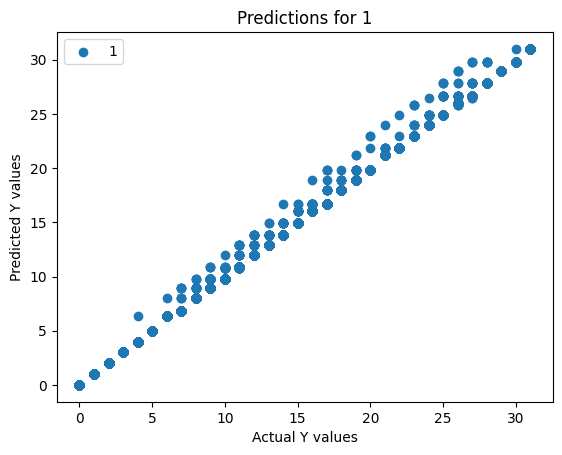

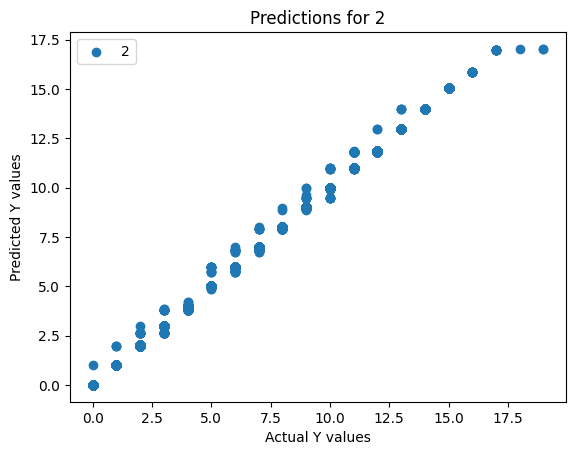

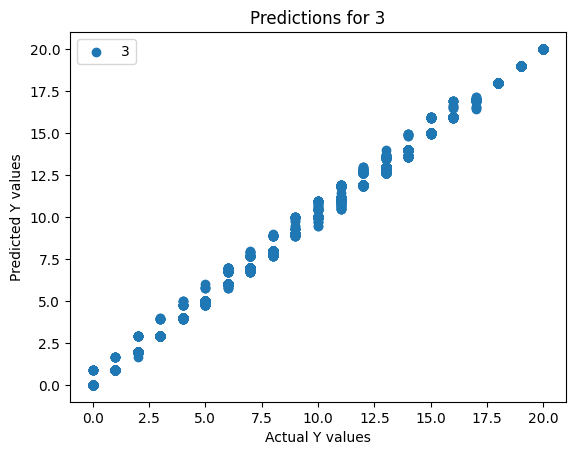

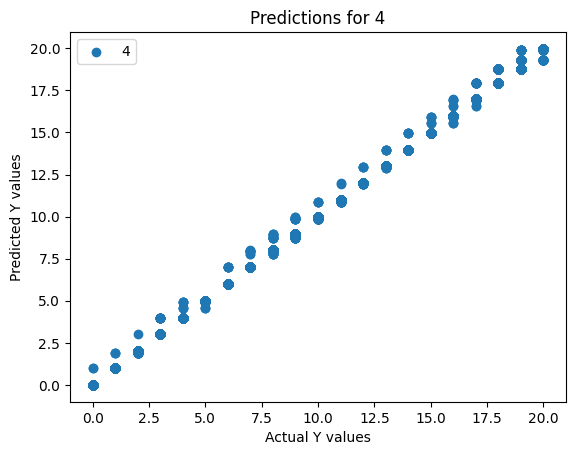

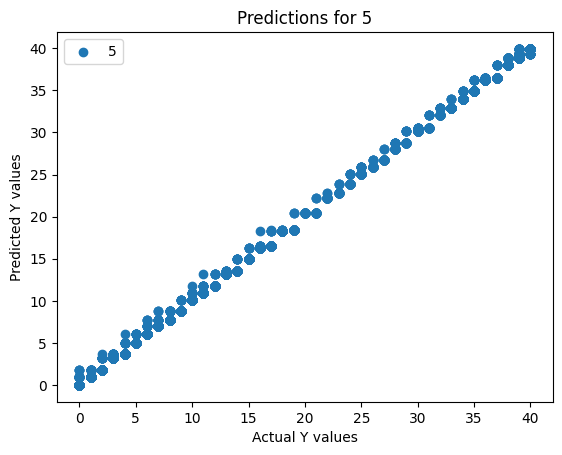

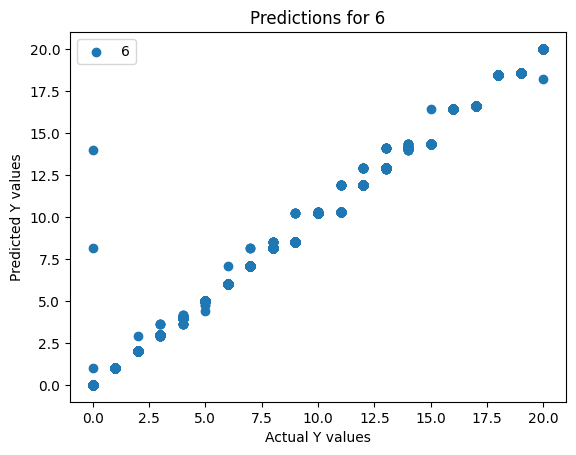

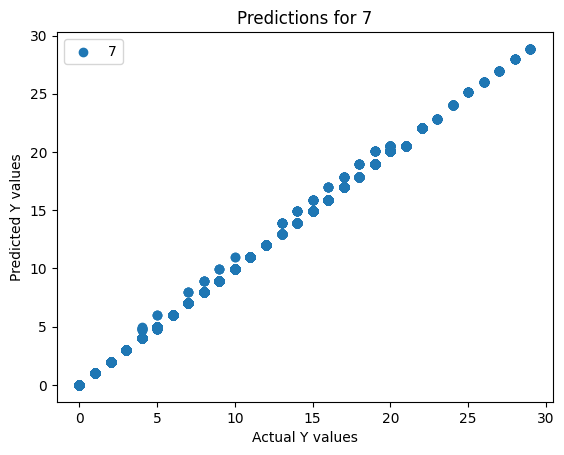

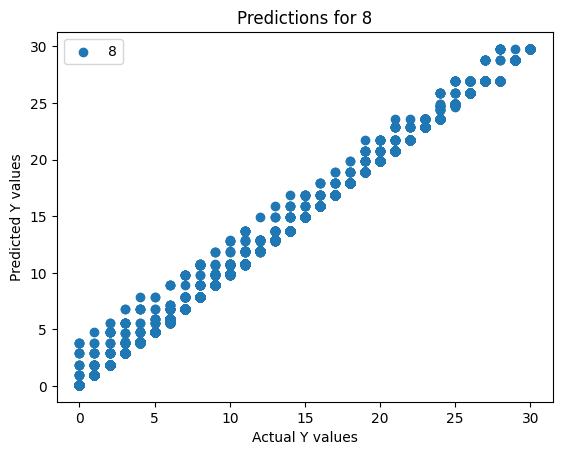

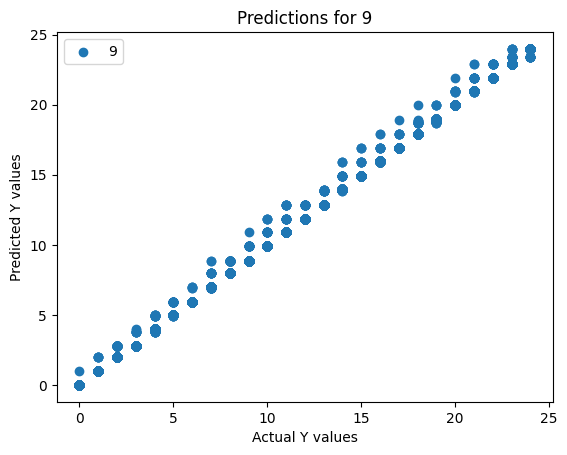

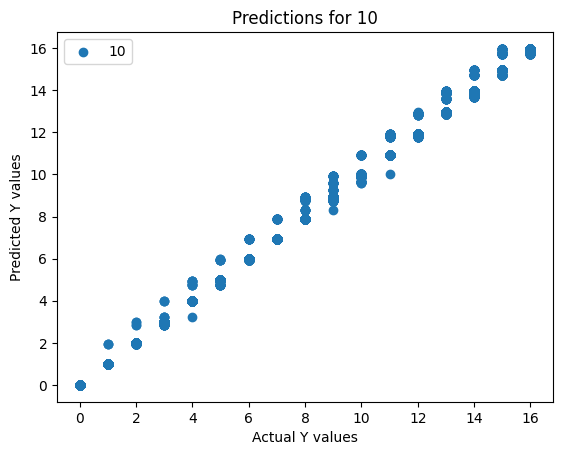

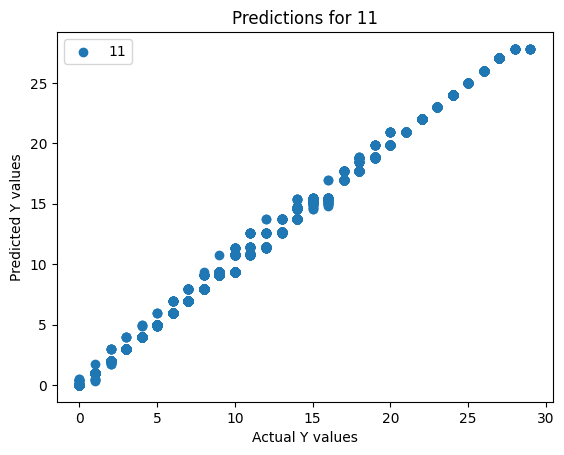

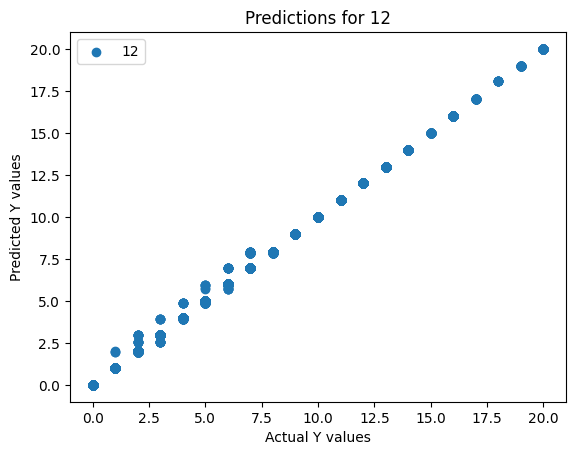

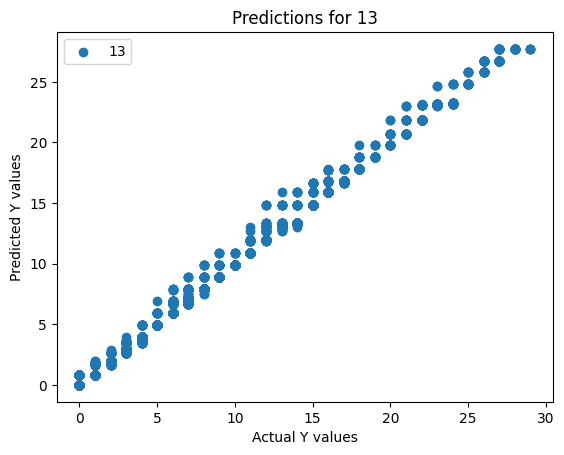

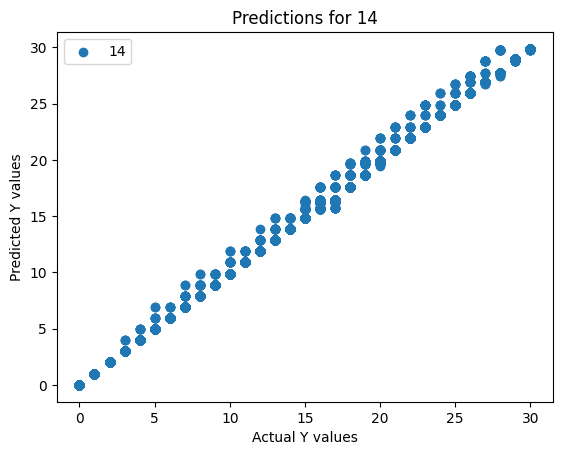

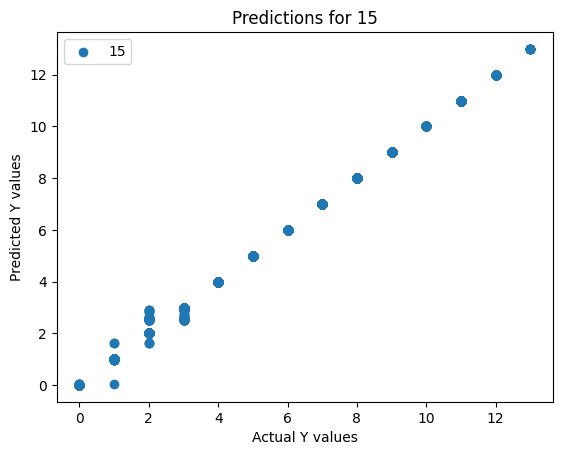

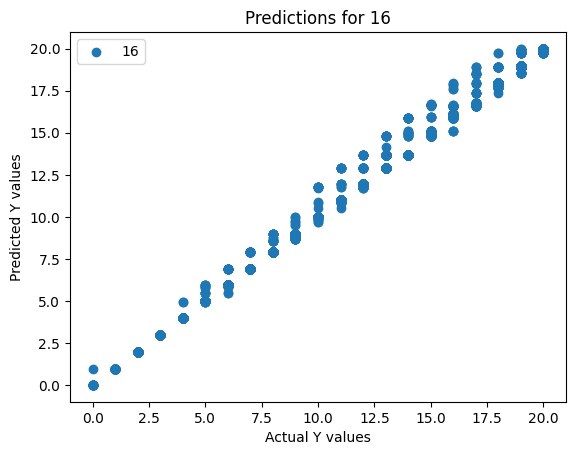

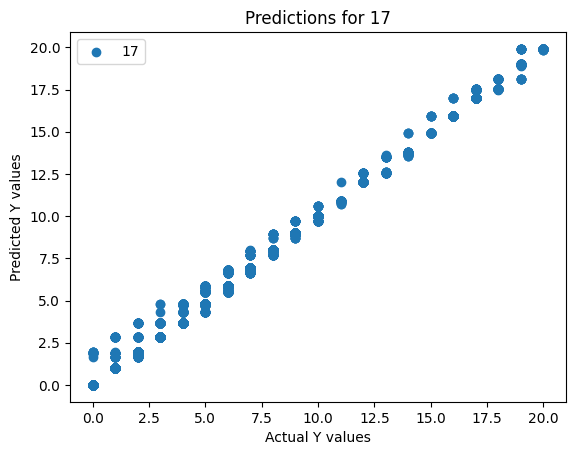

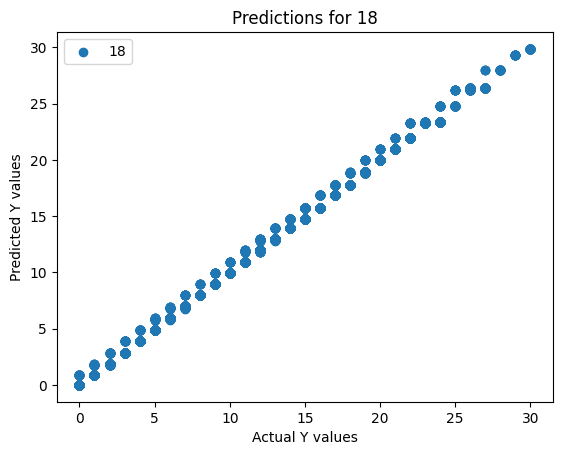

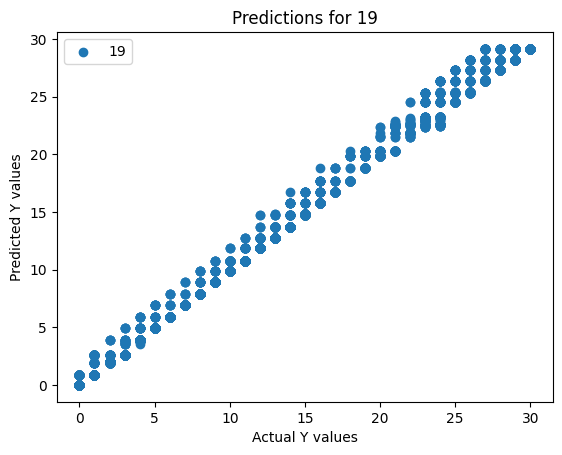

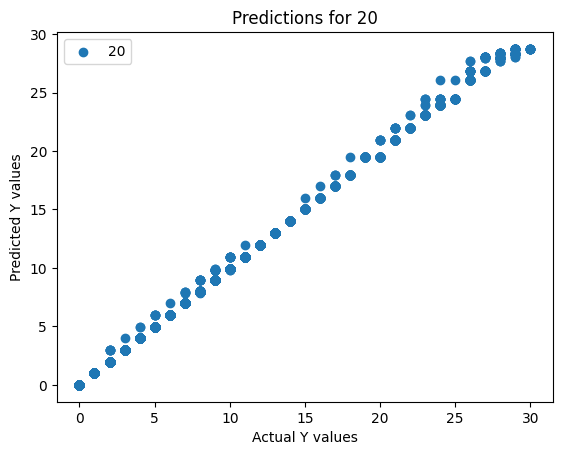

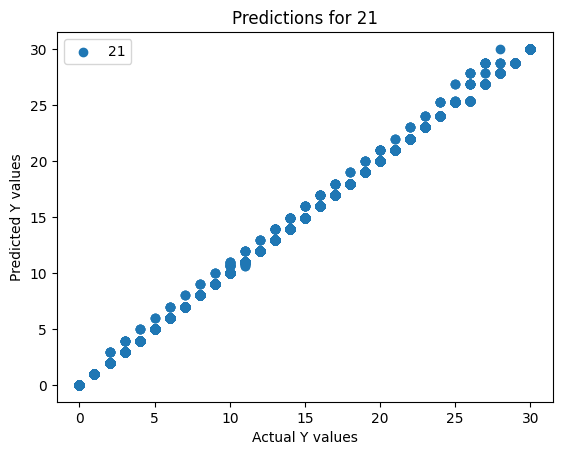

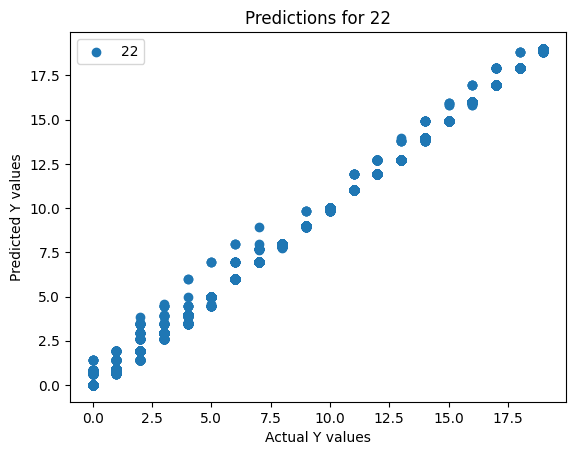

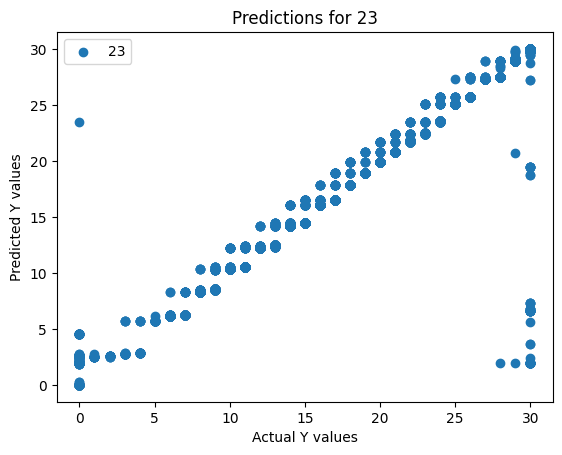

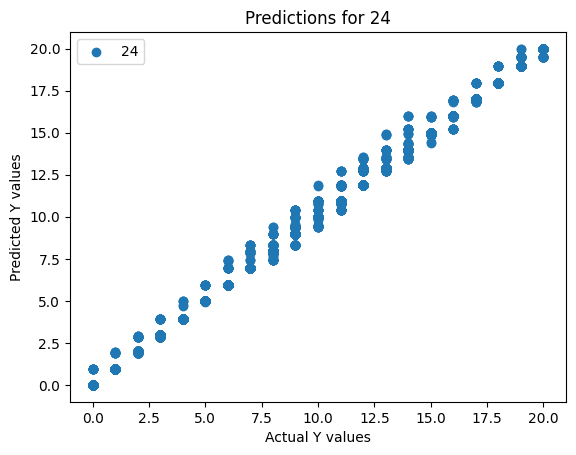

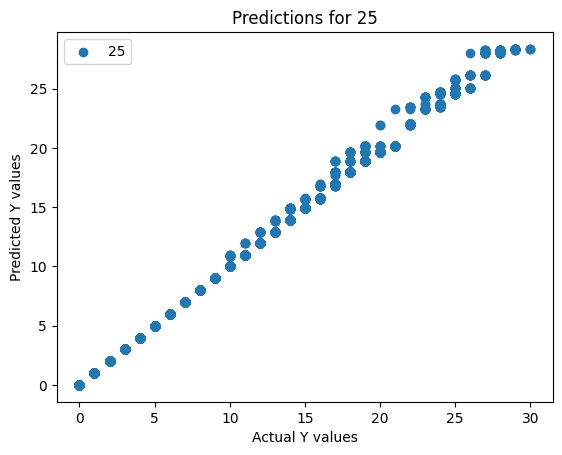

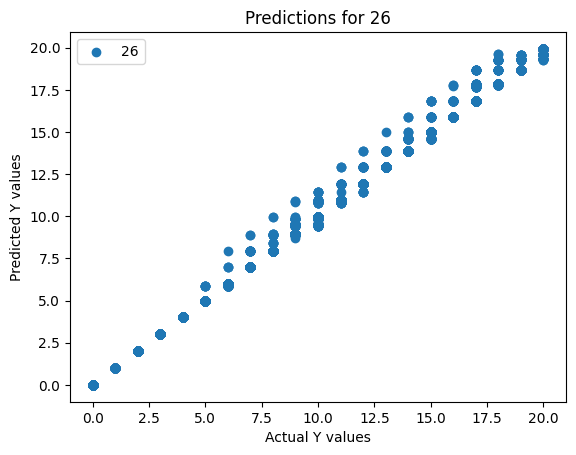

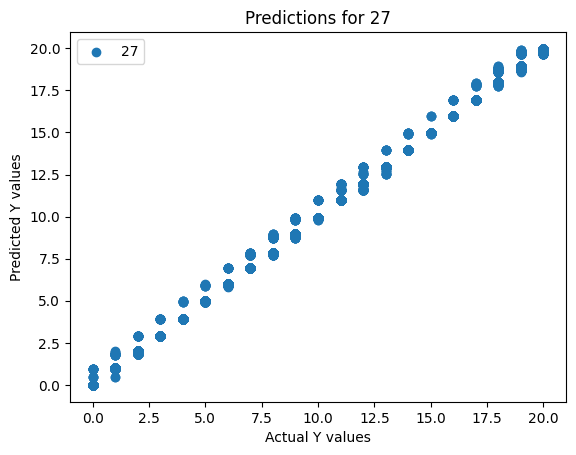

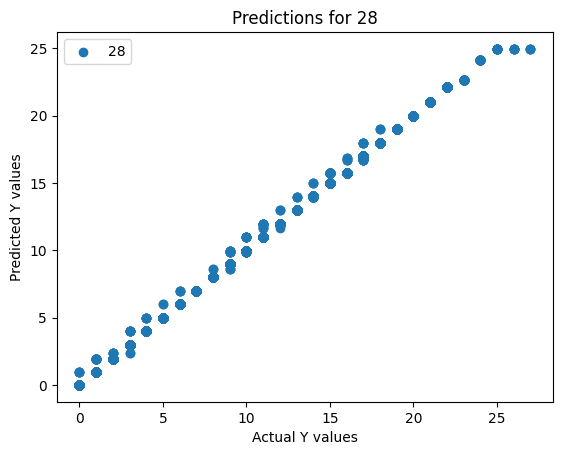

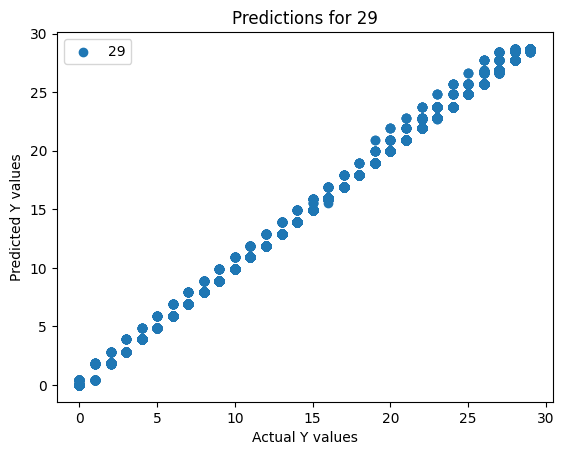

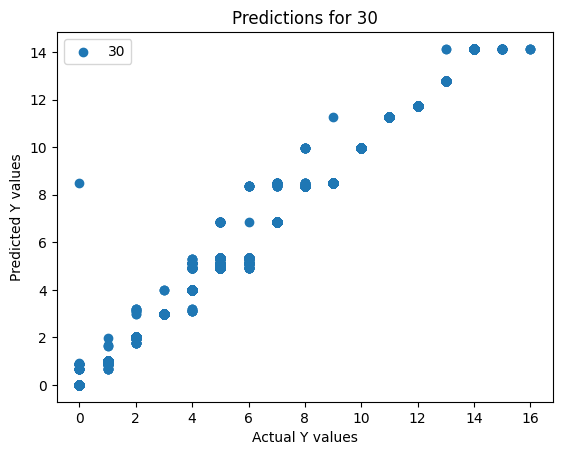

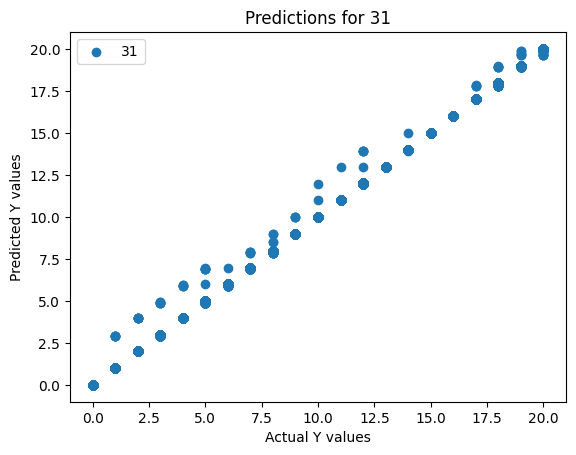

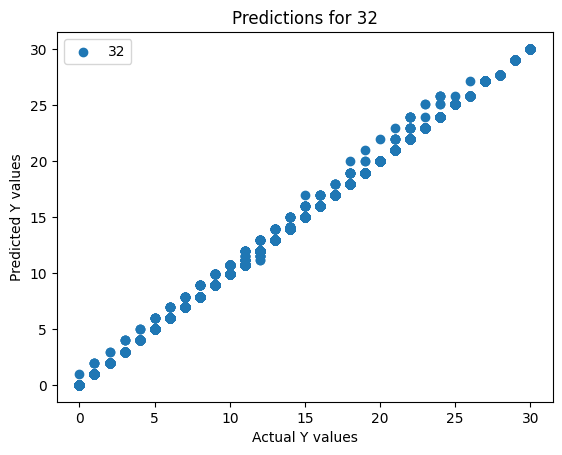

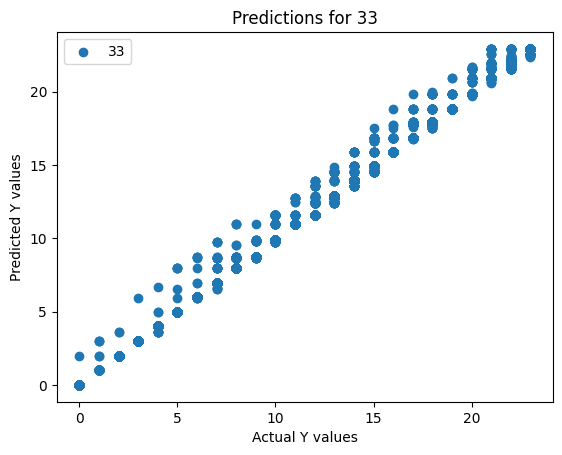

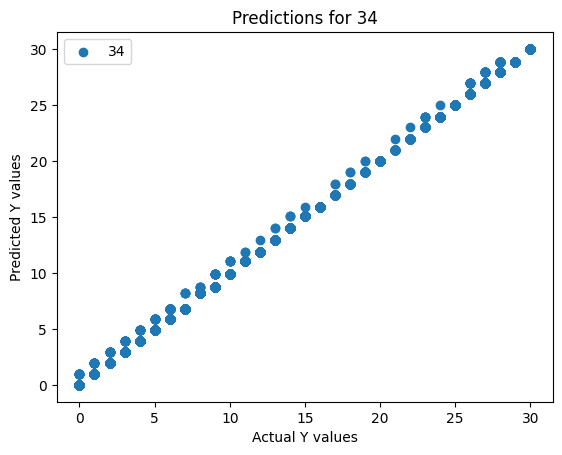

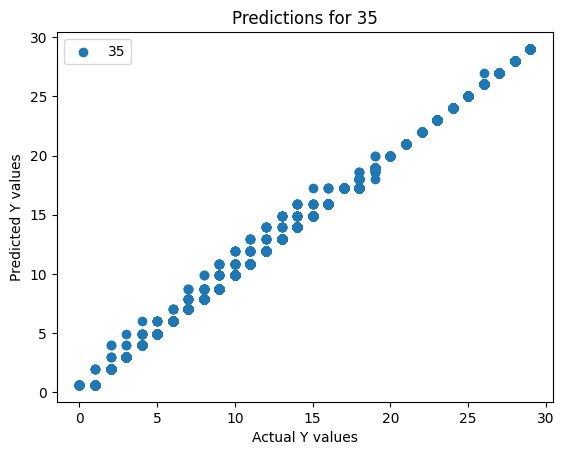

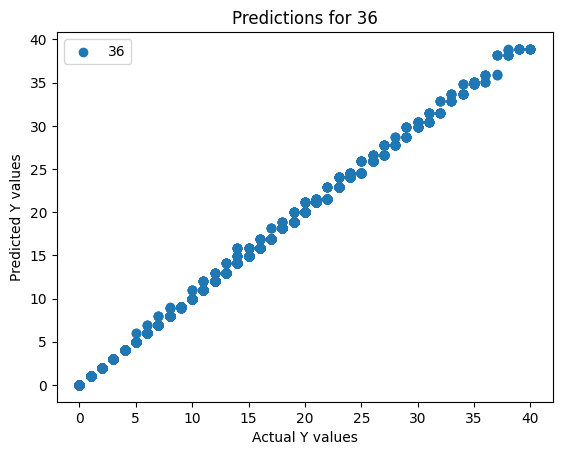

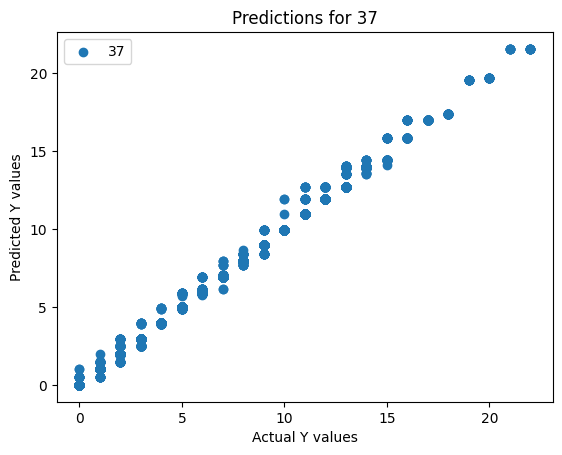

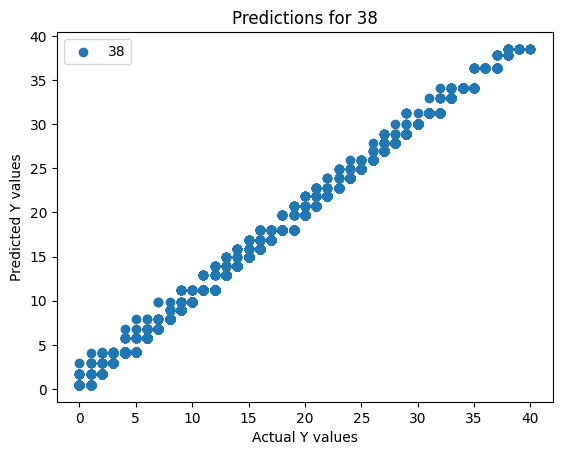

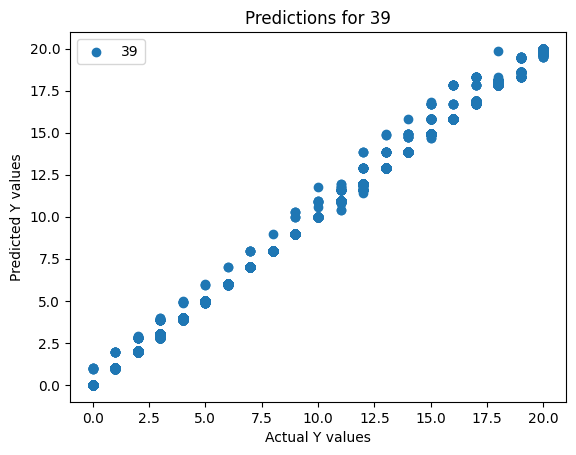

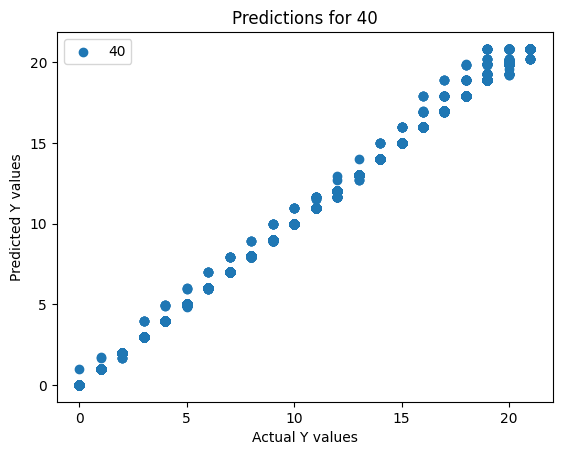

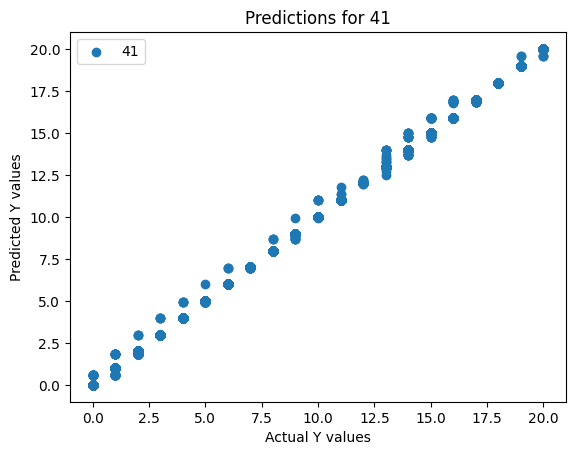

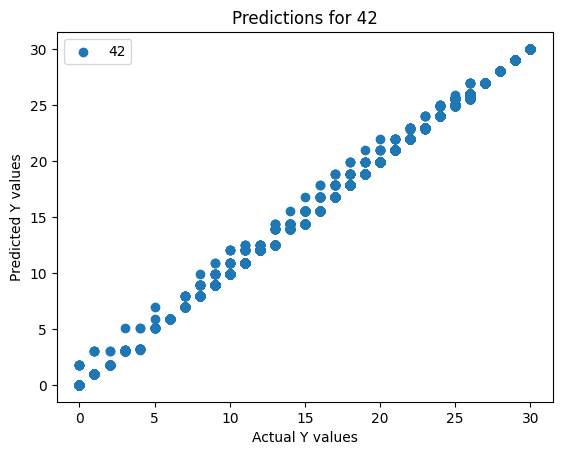

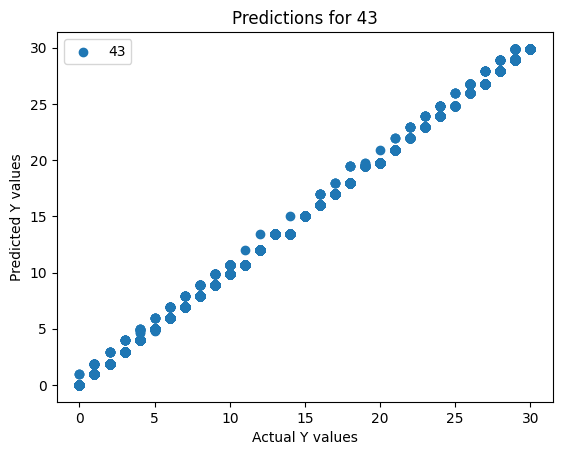

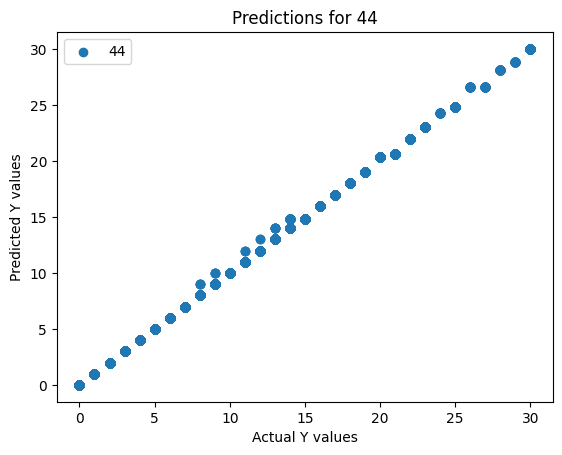

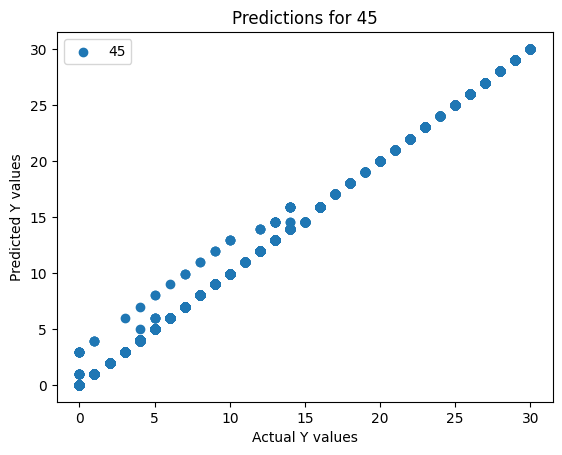

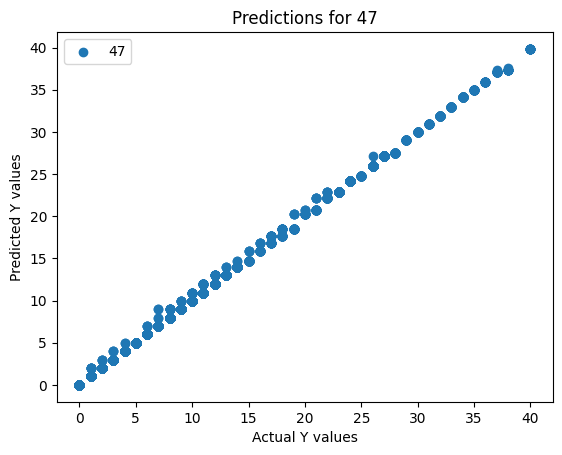

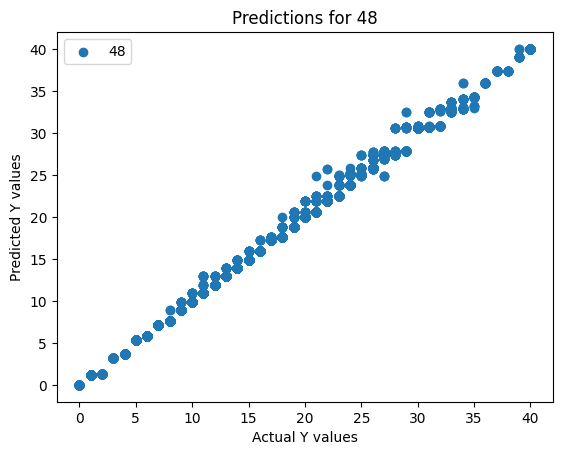

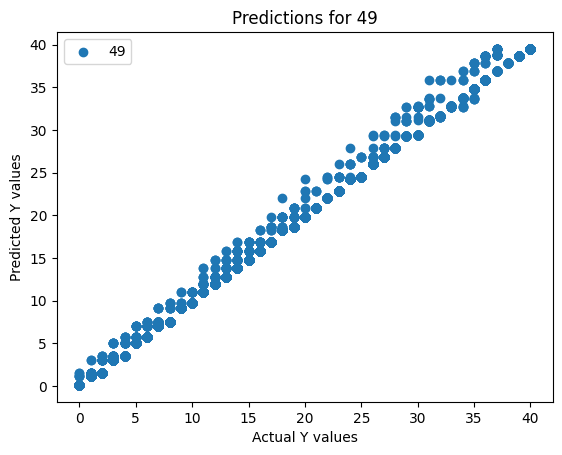

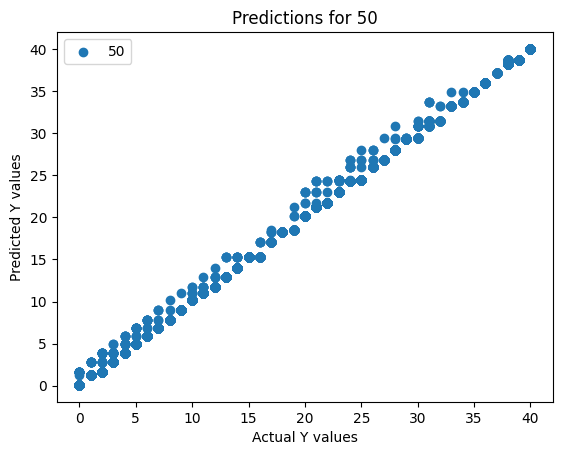

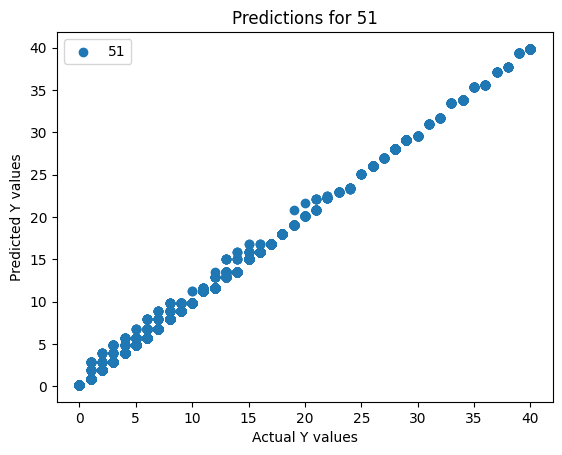

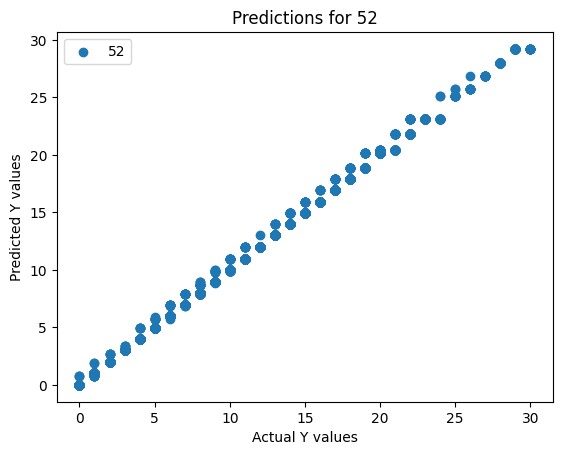

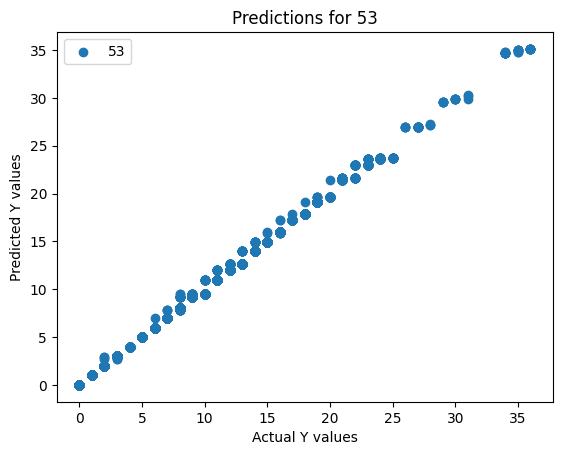

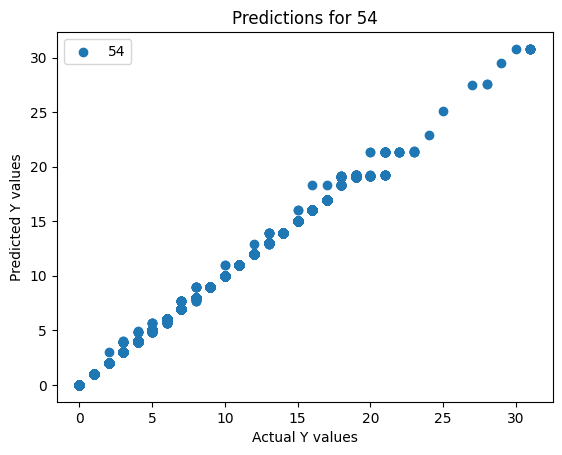

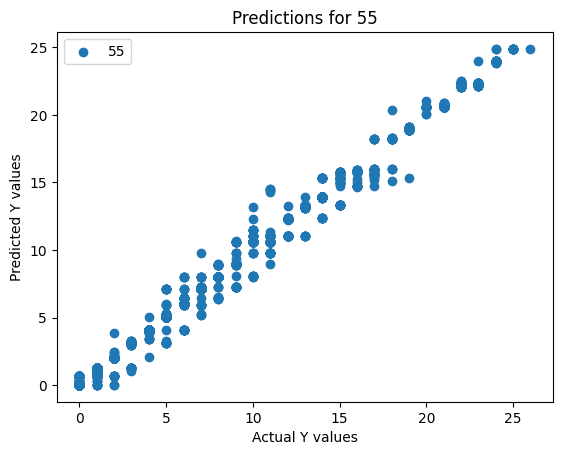

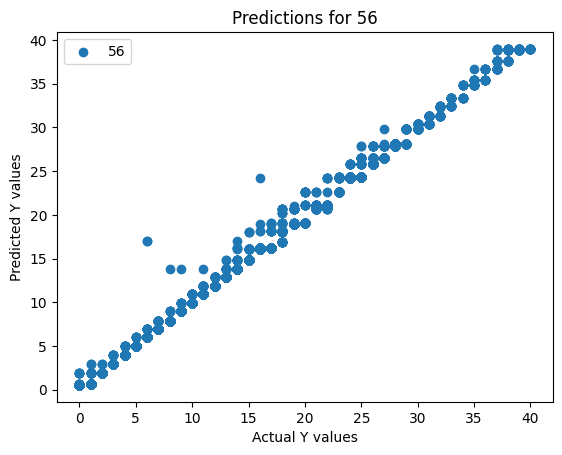

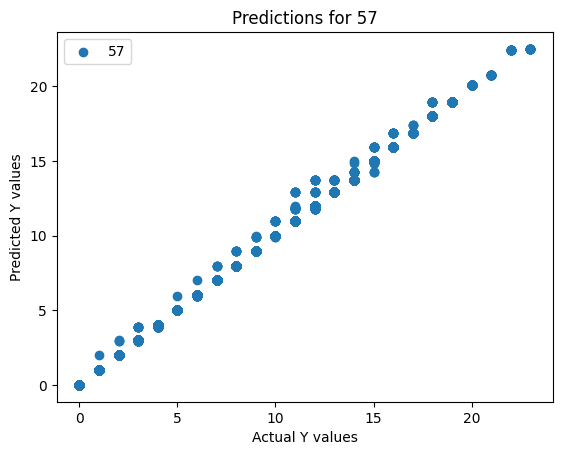

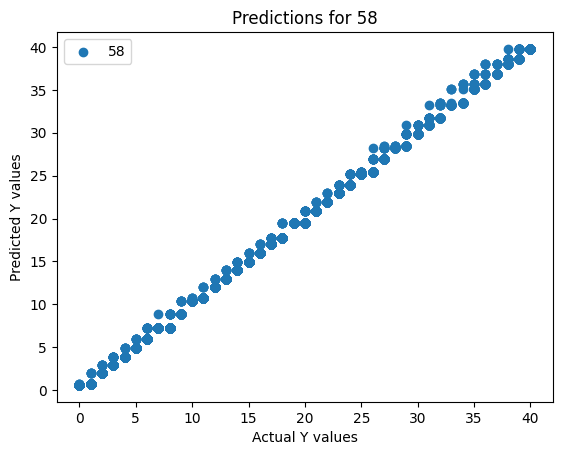

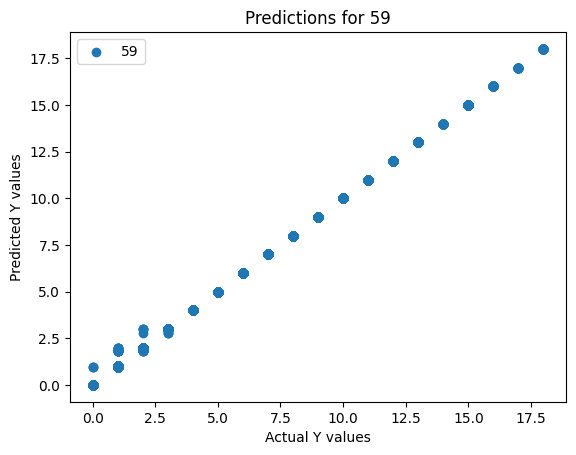

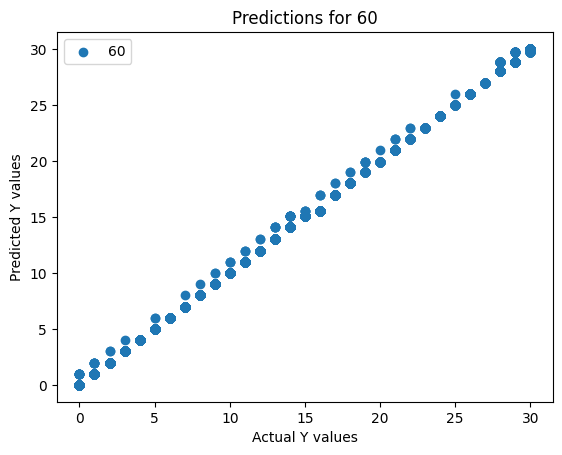

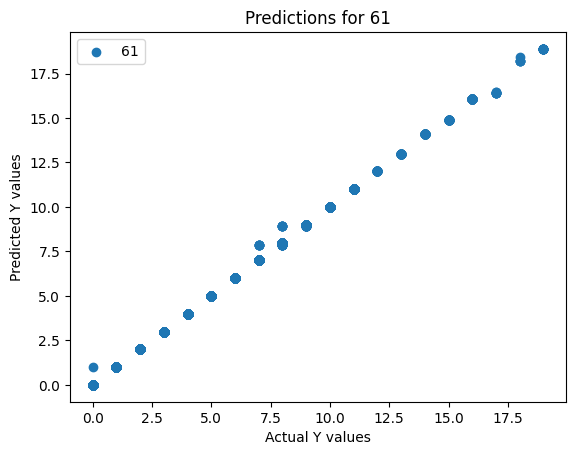

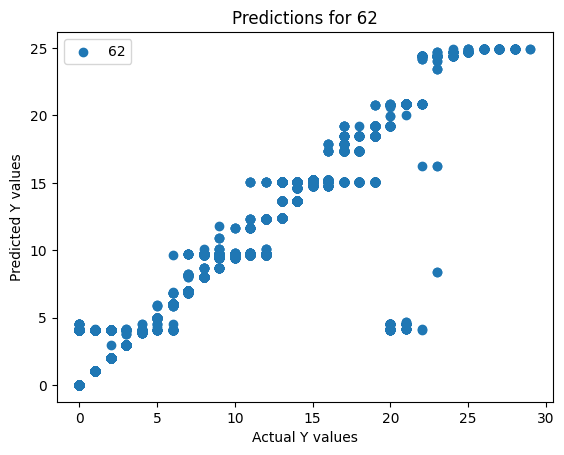

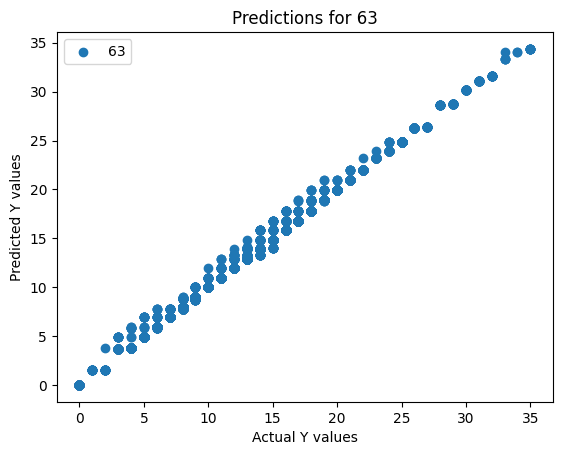

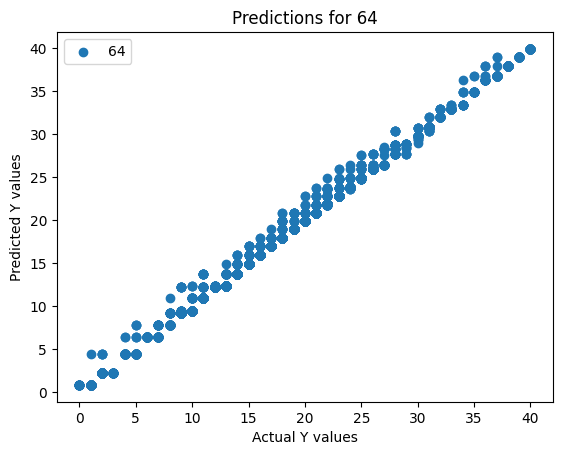

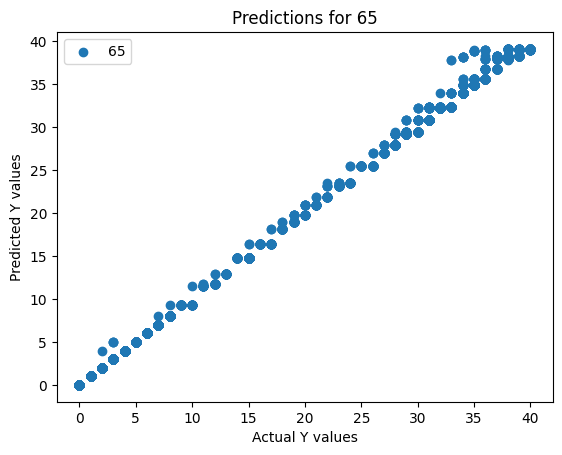

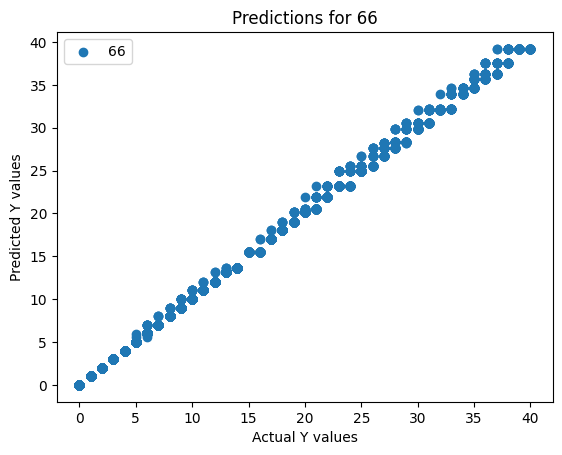

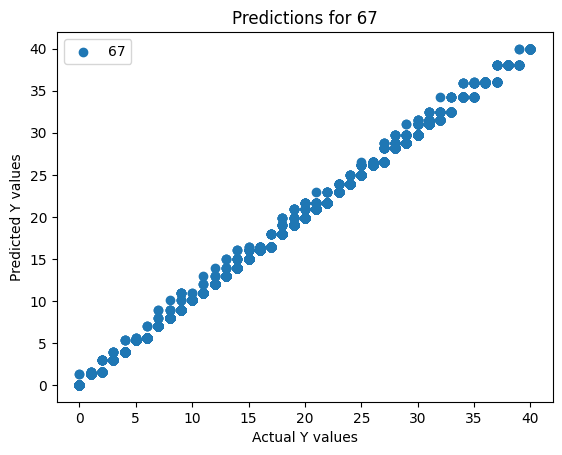

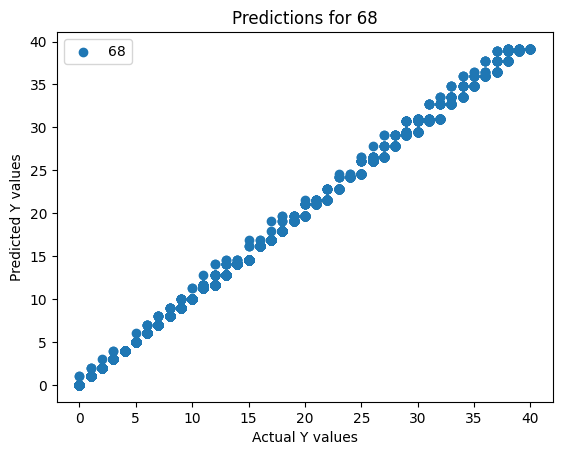

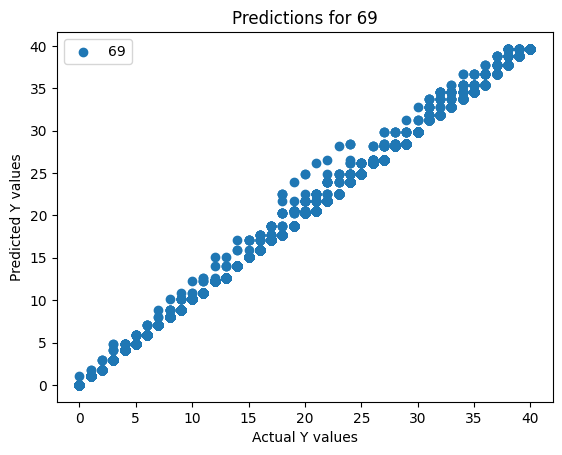

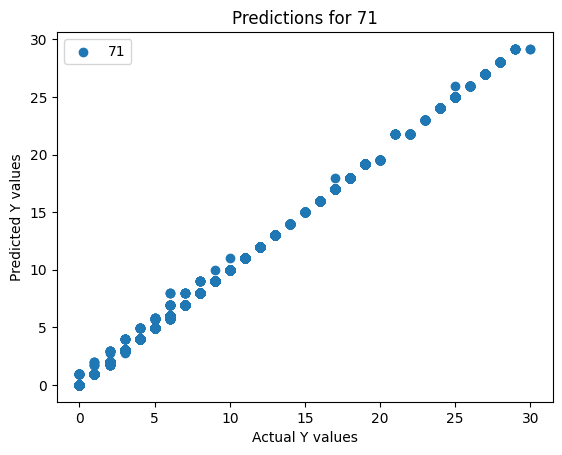

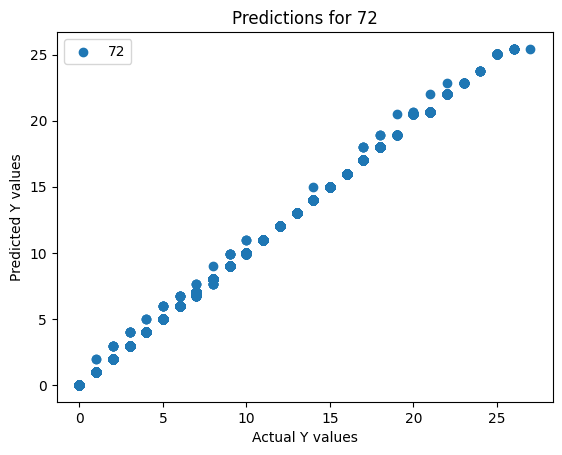

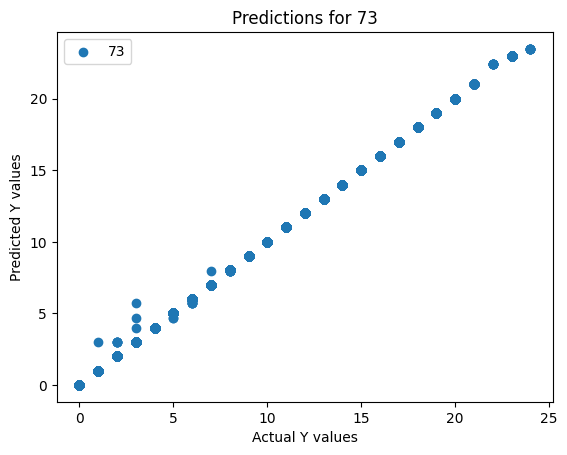

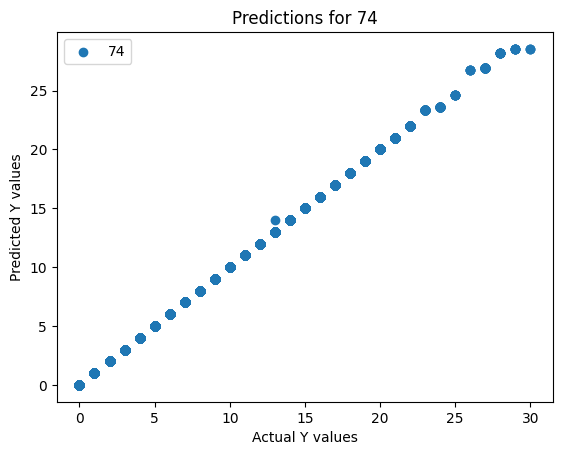

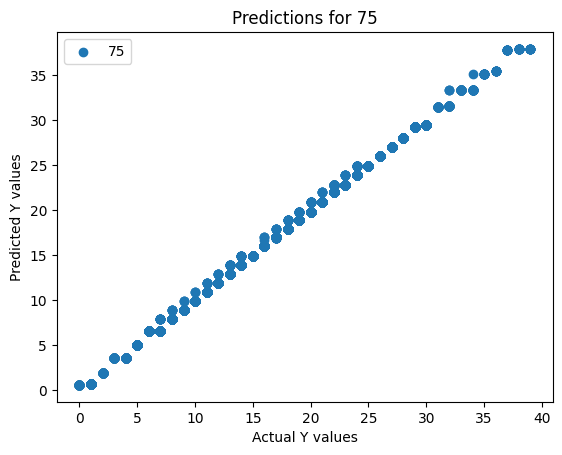

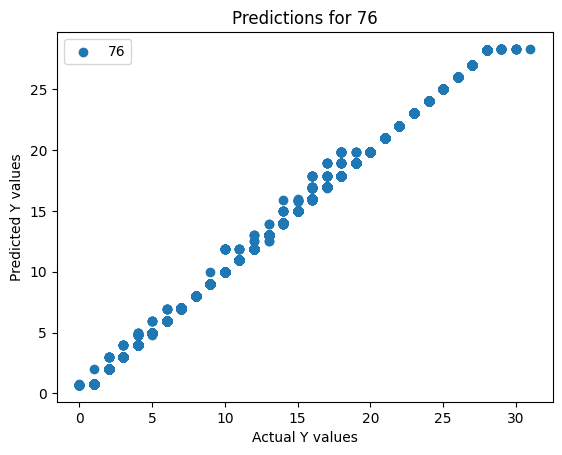

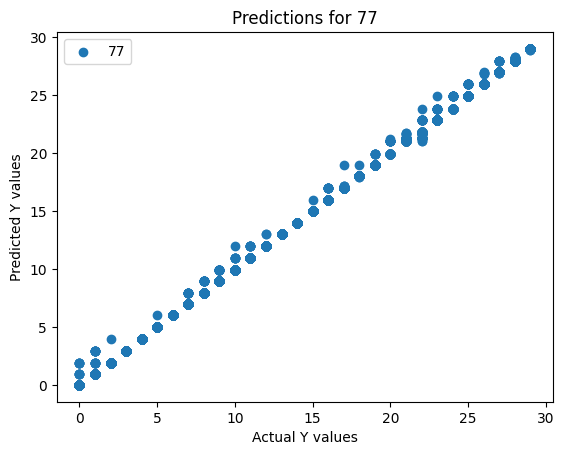

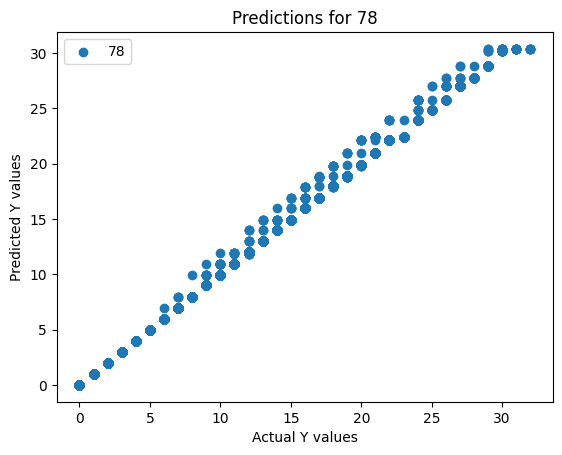

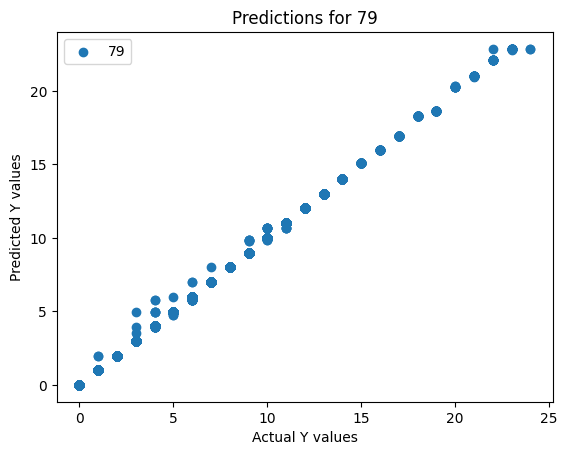

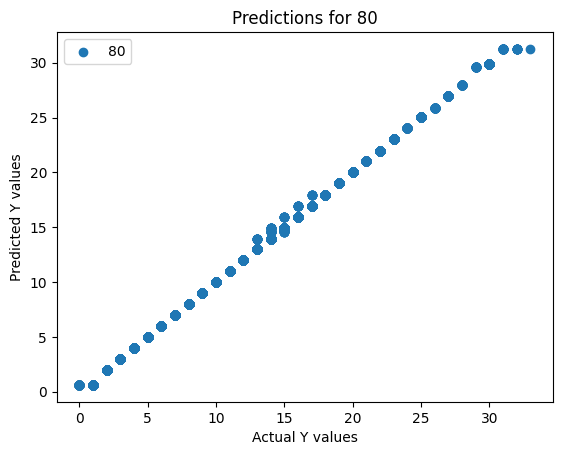

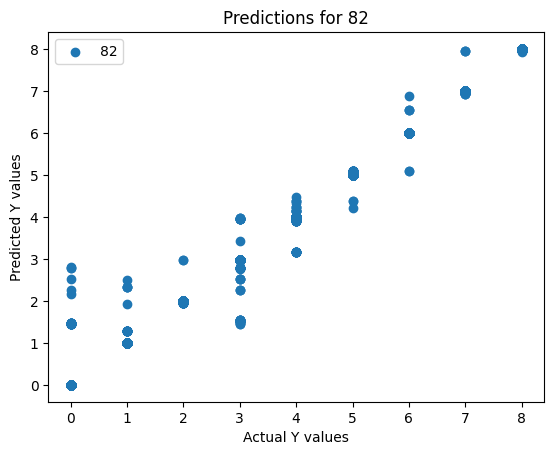

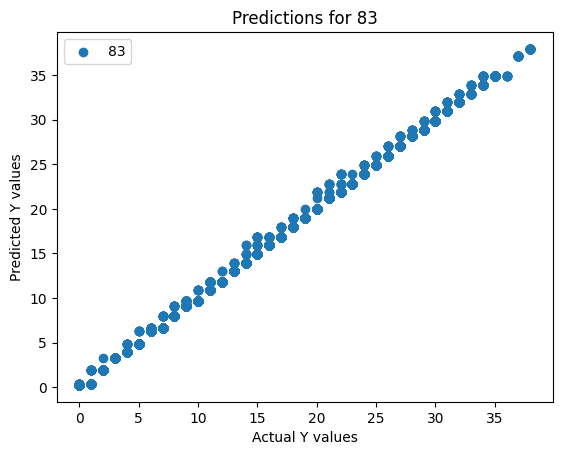

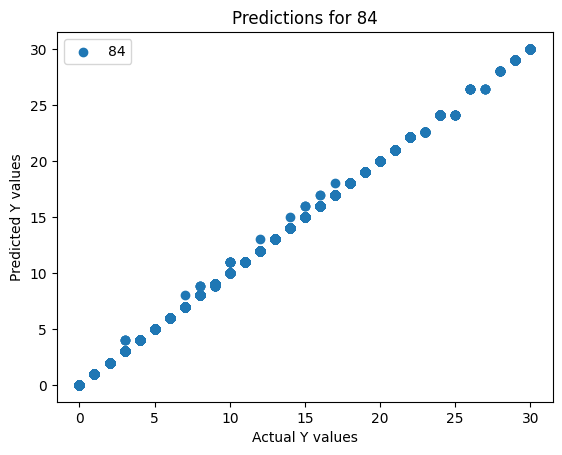

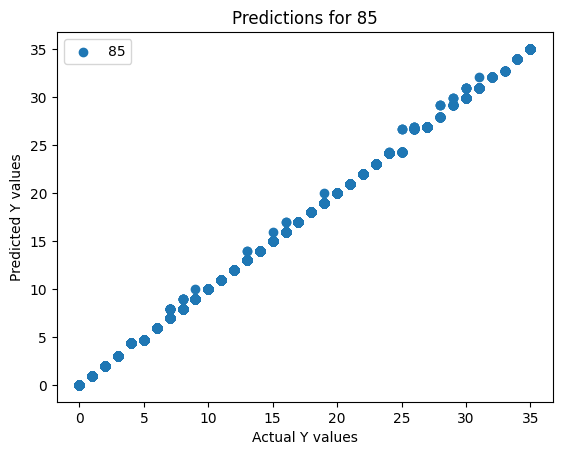

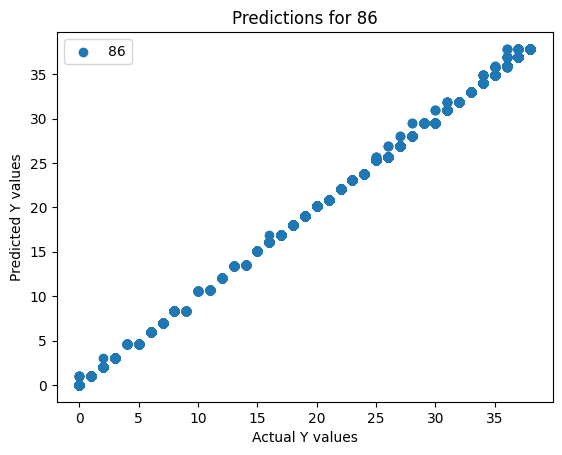

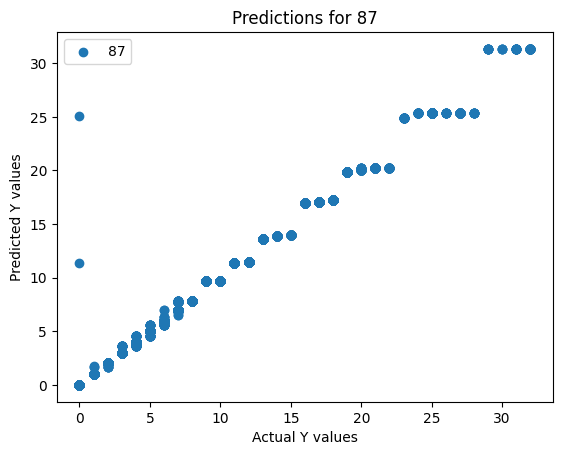

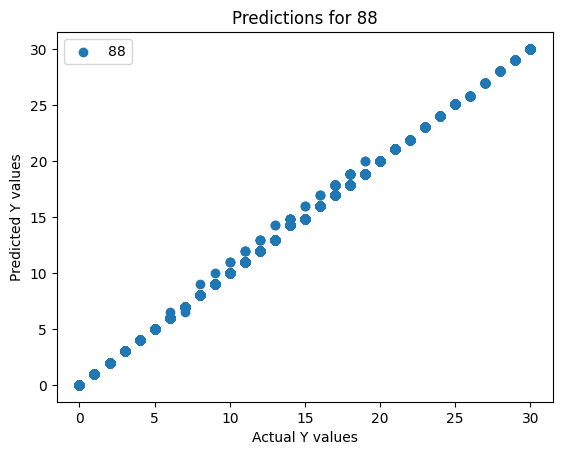

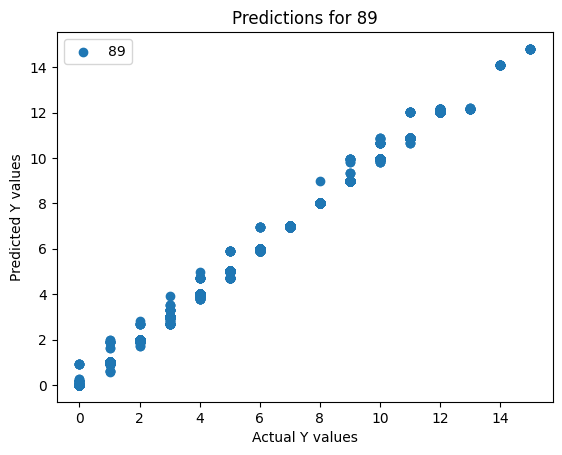

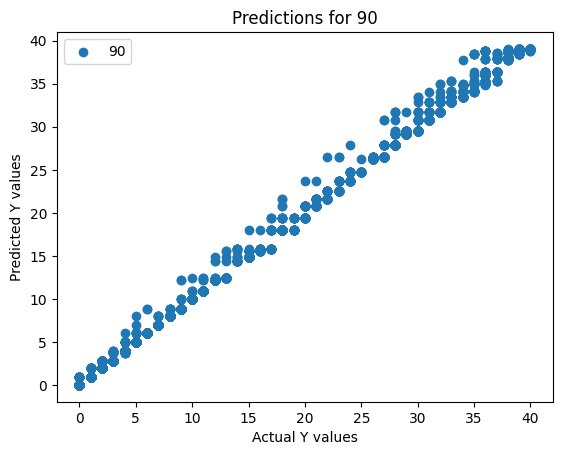

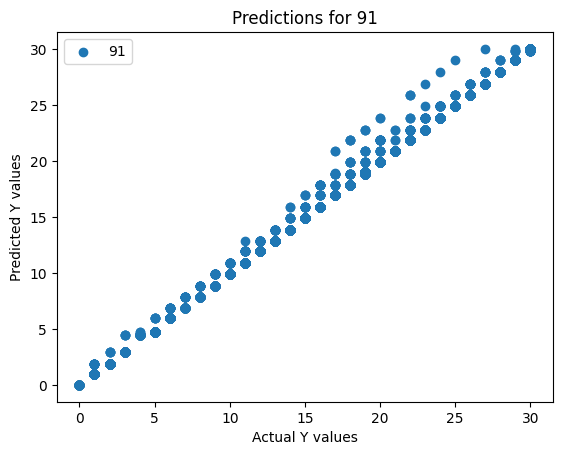

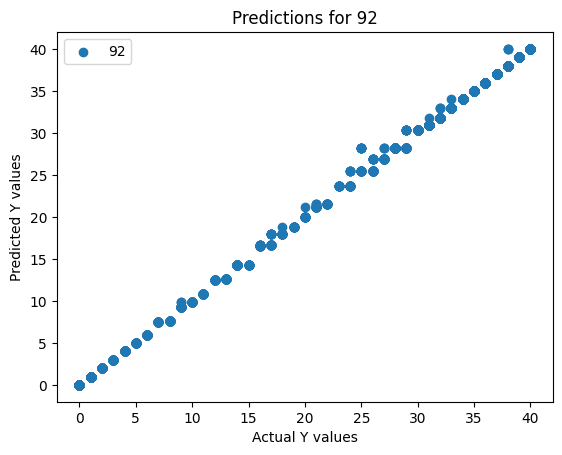

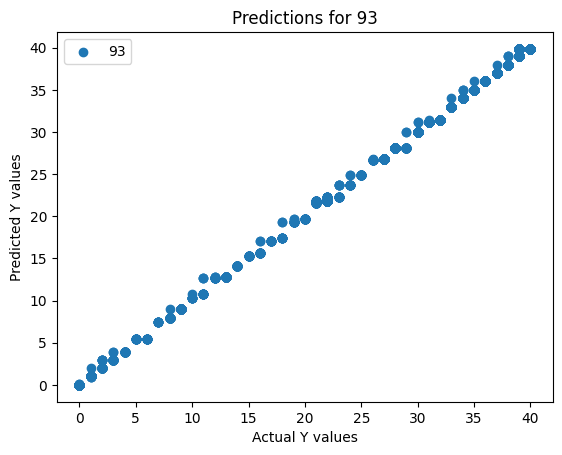

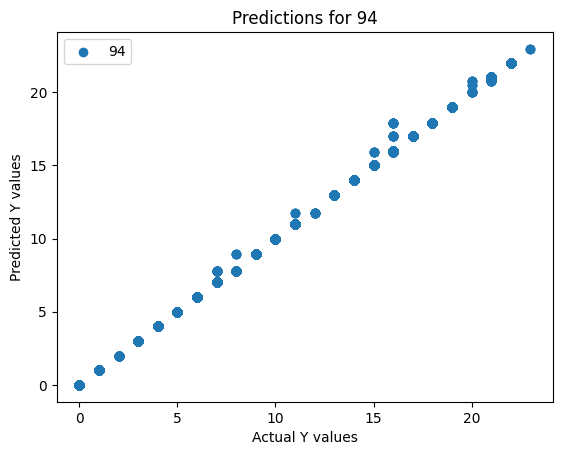

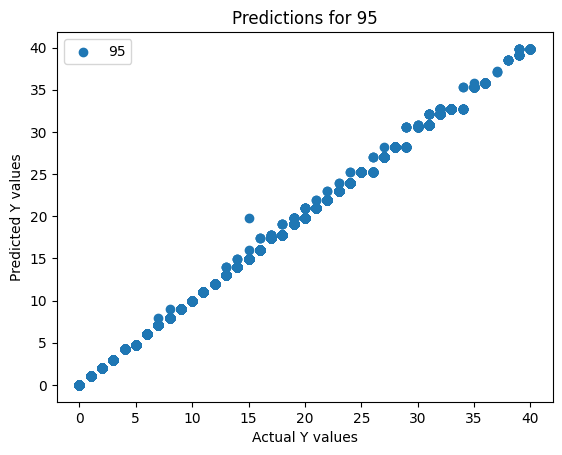

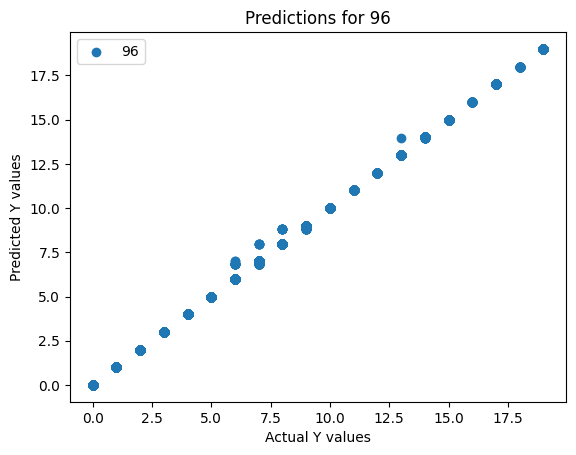

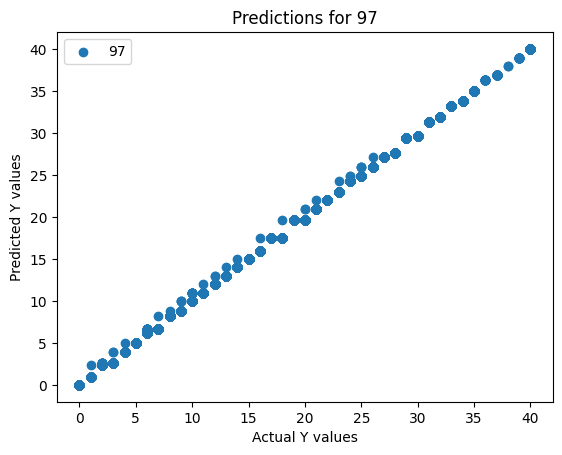

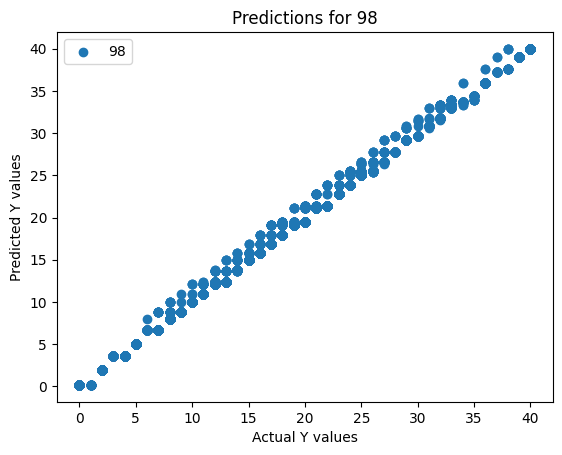

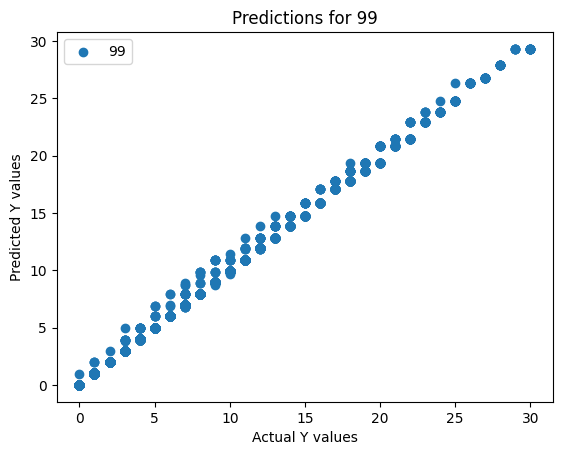

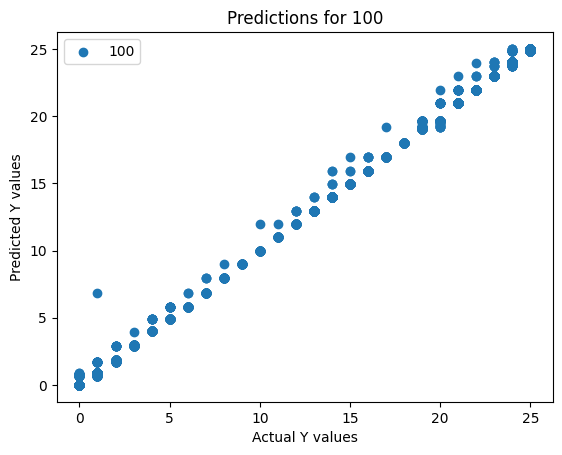

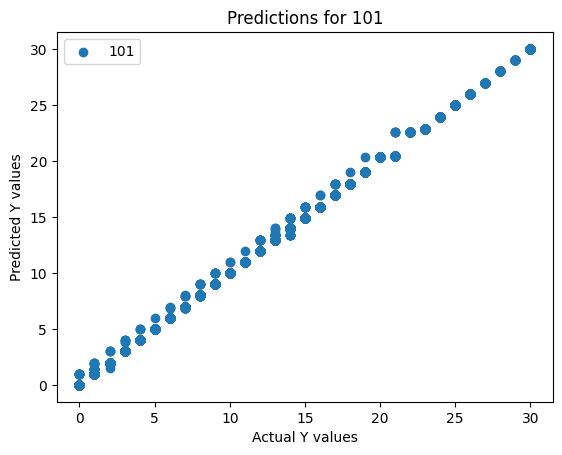

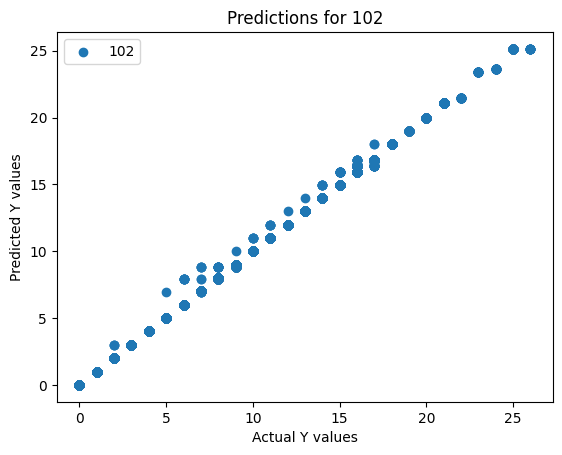

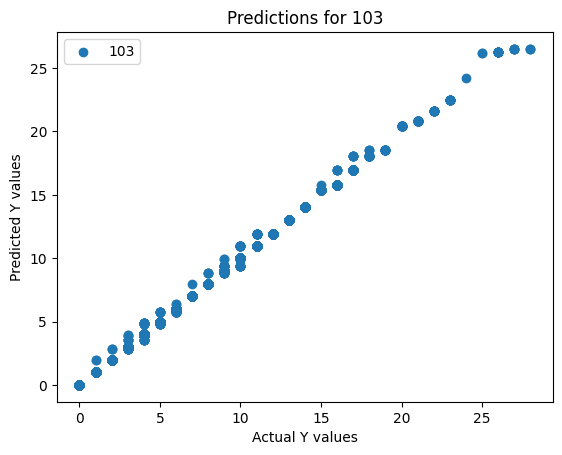

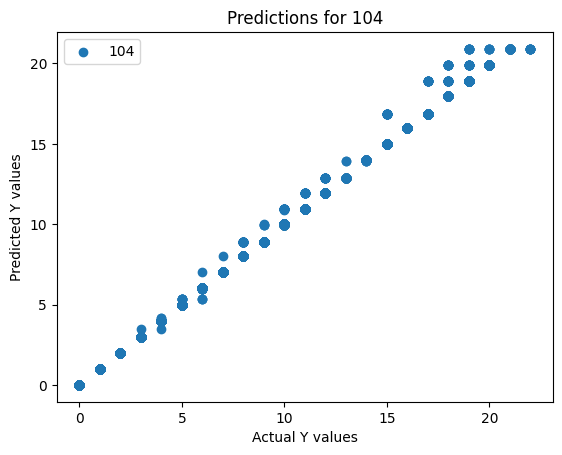

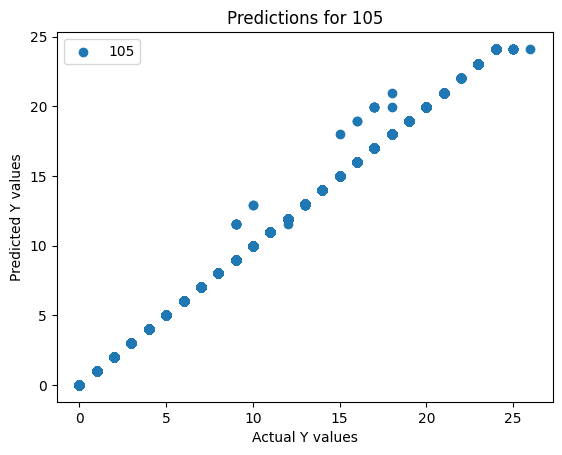

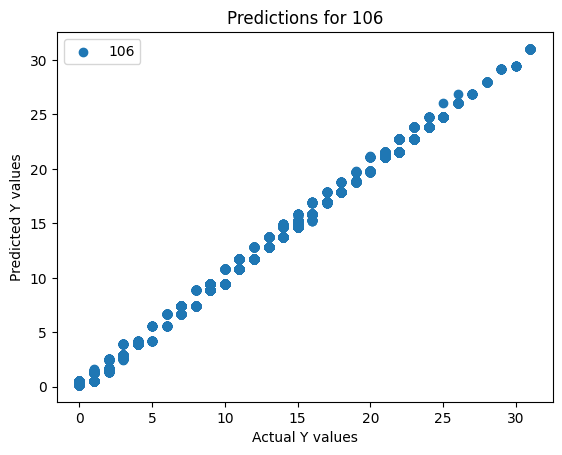

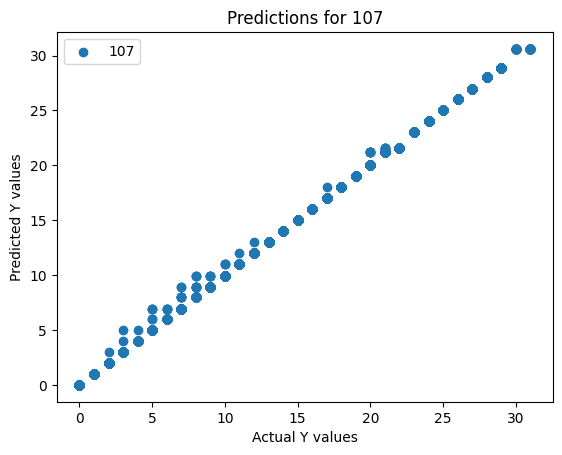

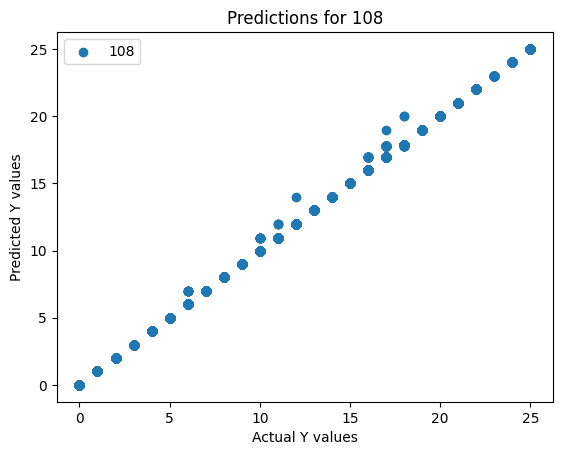

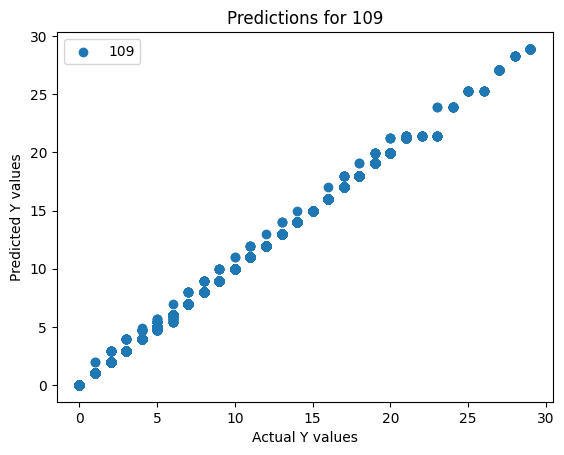

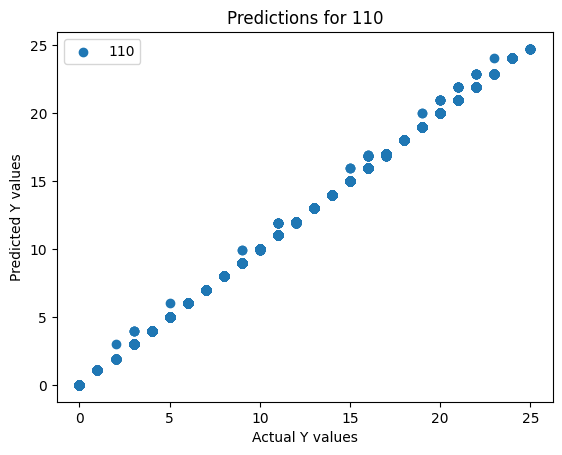

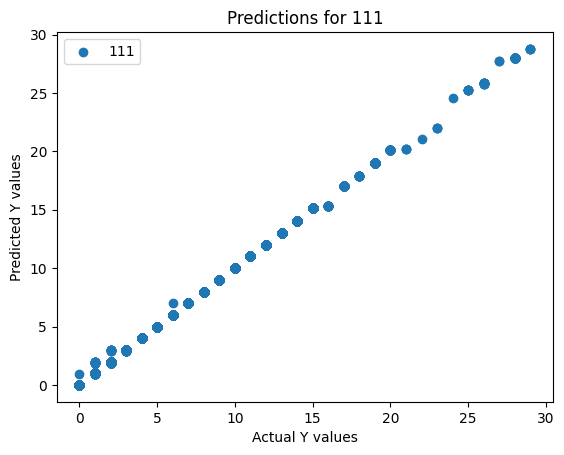

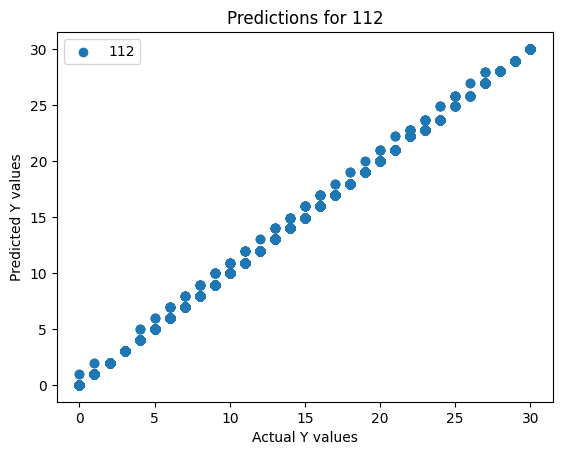

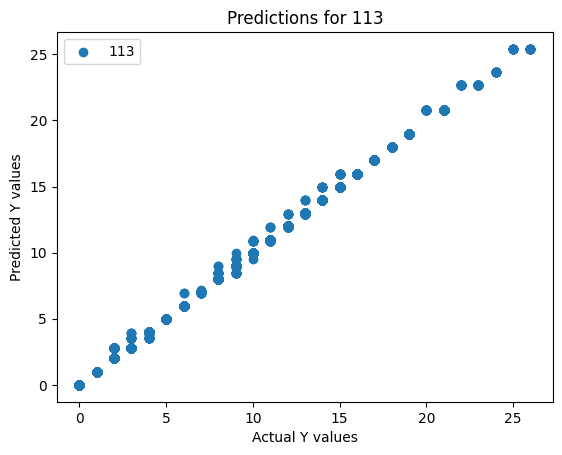

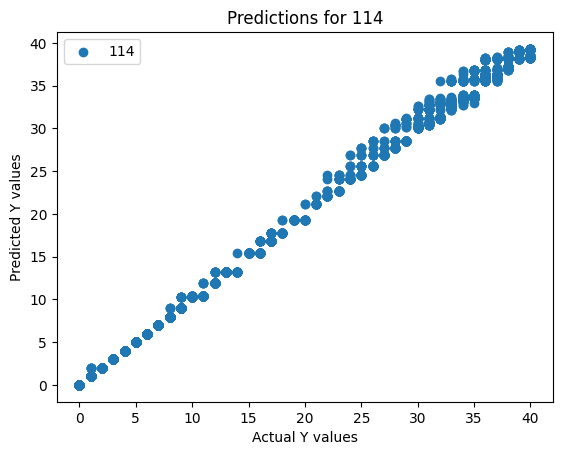

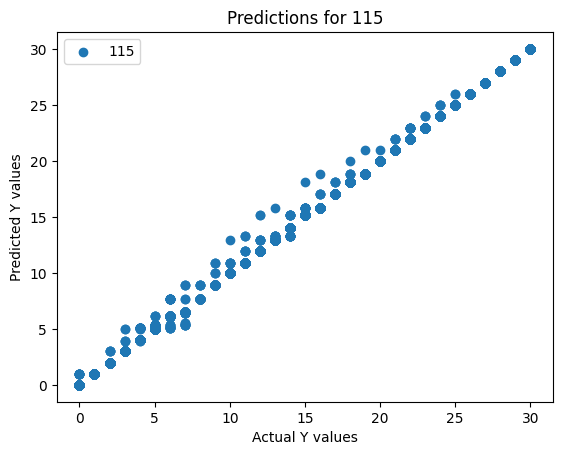

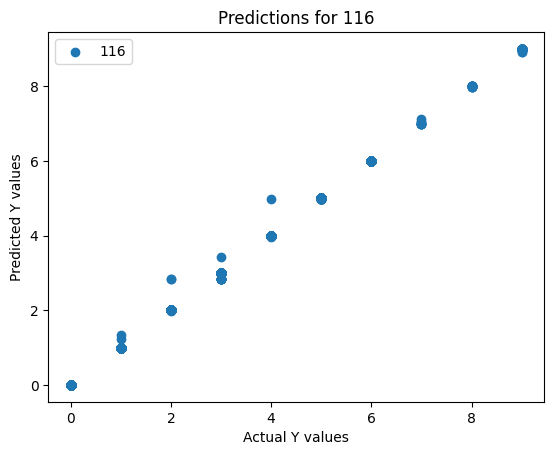

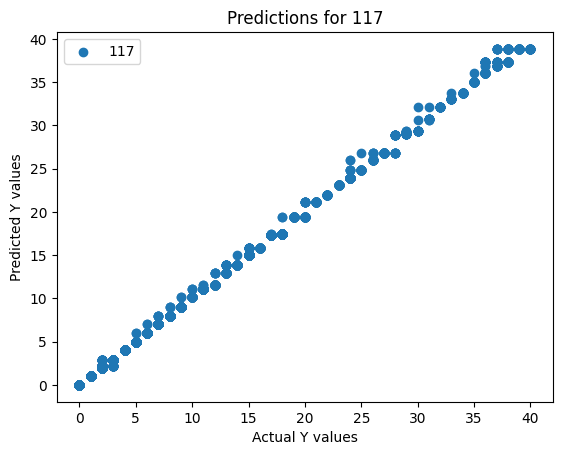

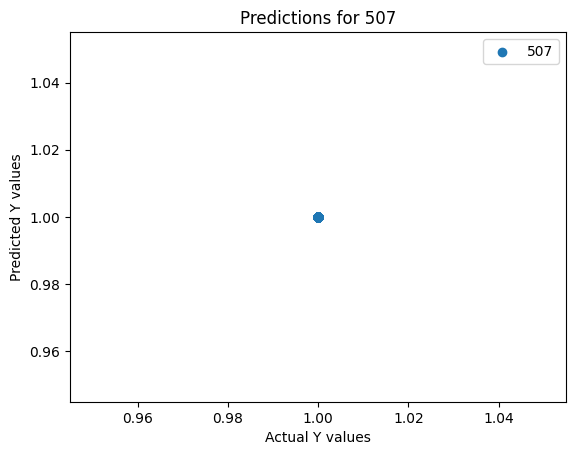

In [ ]:
import matplotlib.pyplot as plt

for model_name, model in models.items():
    fig, ax = plt.subplots()
    ax.set_title(f"Predictions for {model_name}")
    for station_name, station_df in stations:
        if station_name == model_name:
            x = station_df.drop("available_bikes", axis=1)
            prediction = model.predict(x)
            y_actual = station_df["available_bikes"].values # extract actual y values
            ax.scatter(y_actual, prediction, label=station_name) # plot actual vs predicted with different marker

    ax.set_xlabel("Actual Y values")
    ax.set_ylabel("Predicted Y values")
    ax.legend()
    plt.show()

            


## Saving models to pickle files

In [ ]:
import pickle

with open("models.pkl", "wb") as f:
    pickle.dump(models, f)

FileNotFoundError: [Errno 2] No such file or directory: 'models.pkl'